In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c aptos2019-blindness-detection

100% 9.50G/9.51G [00:52<00:00, 234MB/s]
100% 9.51G/9.51G [00:52<00:00, 195MB/s]


In [ ]:
mkdir images

In [ ]:
! unzip aptos2019-blindness-detection.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/test_images/512beaada8f0.png  
  inflating: train/test_images/51323e9d2070.png  
  inflating: train/test_images/515675001b9e.png  
  inflating: train/test_images/515877da2def.png  
  inflating: train/test_images/5168ddccea88.png  
  inflating: train/test_images/5172c056a687.png  
  inflating: train/test_images/5177461f5339.png  
  inflating: train/test_images/51910bcb980d.png  
  inflating: train/test_images/51a3e9b6a1c0.png  
  inflating: train/test_images/51bbd82feec8.png  
  inflating: train/test_images/51de5fb8eccd.png  
  inflating: train/test_images/51e88694c81f.png  
  inflating: train/test_images/51f0bf8f1544.png  
  inflating: train/test_images/51f57fb32840.png  
  inflating: train/test_images/51fa42dc1415.png  
  inflating: train/test_images/5276ab33b7b0.png  
  inflating: train/test_images/52a353760f72.png  
  inflating: train/test_images/531937254e73.png  
  inflating: train/test_images/5325b1c22c61.png  

In [ ]:
import numpy as np 
import pandas as pd 
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from tqdm import tqdm_notebook as tqdm

import random
import math
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [ ]:
import fastai

fastai.__version__

'1.0.61'

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.basic_data import DatasetType

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#tfms=get_transforms(do_flip=True,flip_vert=True,max_lighting=0.3,max_zoom=1.8,max_warp=0.2,max_rotate=45)

In [ ]:
train = pd.read_csv('/content/train/train.csv')
test = pd.read_csv('/content/train/test.csv')

In [ ]:
train['id_code'] = train['id_code'] + '.png'

In [ ]:
train.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [ ]:
data = ImageDataBunch.from_df('/content/train/train_images',
                              train,
                              size=224,
                              valid_pct=0.20,
                              num_workers=2,
                              bs=8,
                             ).normalize(imagenet_stats)

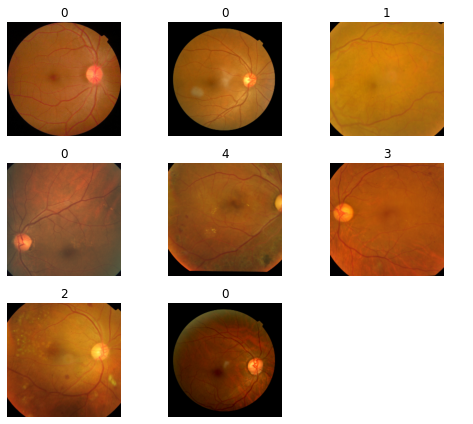

In [ ]:
data.show_batch(rows=5, figsize=(7,6),recompute_scale_factor=True)

In [ ]:
print(data.classes)
len(data.classes)
data.c

[0, 1, 2, 3, 4]


5

In [ ]:
data

ImageDataBunch;

Train: LabelList (2930 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,4,1,0,4
Path: /content/train/train_images;

Valid: LabelList (732 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,1,0,1,2
Path: /content/train/train_images;

Test: None

In [ ]:
from fastai import metrics

In [ ]:
??metrics

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


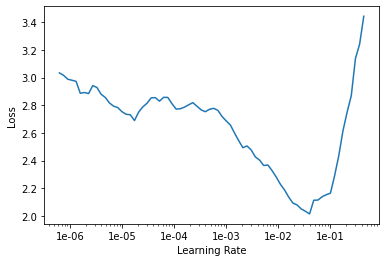

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestions=True)

In [ ]:
lr1 = 1e-4
lr2 = 1e-3
learn.fit_one_cycle(4,slice(lr1,lr2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.129239,0.844990,0.274590,0.725410,08:38
1,0.987961,0.702454,0.226776,0.773224,09:01
2,0.730089,0.630308,0.233607,0.766393,09:00
3,0.688306,0.629359,0.228142,0.771858,09:18


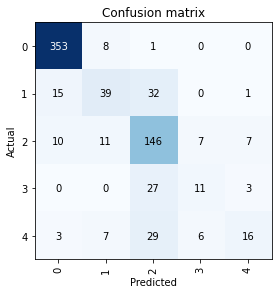

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Applying Data Transformation

In [ ]:
tfms=get_transforms(do_flip=True,flip_vert=True,max_lighting=0.3,max_zoom=1.8,max_warp=0.2,max_rotate=45)

In [ ]:
data_aug = ImageDataBunch.from_df('/content/train/train_images',
                              train,
                              size=224,
                              valid_pct=0.20,
                              ds_tfms=tfms,
                              num_workers=2,
                              bs=8,
                             ).normalize(imagenet_stats)

In [ ]:
learn_aug = cnn_learner(data_aug, models.resnet34, metrics=[error_rate, accuracy])

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


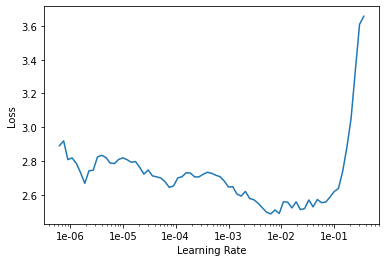

In [ ]:
learn_aug.lr_find()
learn_aug.recorder.plot(suggestions=True)

In [ ]:
lr1 = 1e-4
lr2 = 1e-3
learn_aug.fit_one_cycle(4,slice(lr1,lr2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.429635,0.919329,0.316940,0.683060,08:55
1,1.015943,0.817929,0.275956,0.724044,08:47
2,0.917606,0.709680,0.245902,0.754098,08:46
3,0.934944,0.681673,0.248634,0.751366,08:51


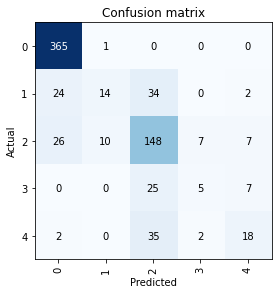

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_aug)
interp.plot_confusion_matrix()

# Coverting the Data to a Binary Classification Problem

### With Data Transformation

In [ ]:
new_data = train.copy()

In [ ]:
new_data['diagnosis'] = [0 if i == 0 else 1 for i in train.diagnosis ]

In [ ]:
tfms=get_transforms(do_flip=True,flip_vert=False,max_lighting=0.3,max_zoom=1.5,max_warp=0.2,max_rotate=60)

In [ ]:
data_aug = ImageDataBunch.from_df('/content/train/train_images',
                              new_data,
                              size=224,
                              valid_pct=0.20,
                              ds_tfms=tfms,
                              num_workers=2,
                              bs=8,
                             ).normalize(imagenet_stats)

In [ ]:
print(data_aug.classes)
len(data_aug.classes)
data_aug.c

[0, 1]


2

In [ ]:
learn_aug = cnn_learner(data_aug, models.resnet34, metrics=[error_rate, accuracy])

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


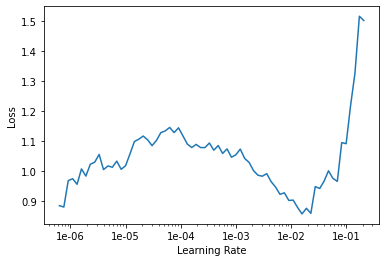

In [ ]:
learn_aug.lr_find()
learn_aug.recorder.plot(suggestions=True)

In [ ]:
lr1 = 1e-4
lr2 = 1e-2
learn_aug.fit_one_cycle(10,slice(lr1,lr2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.458047,0.332210,0.122951,0.877049,09:03
1,0.547318,0.360764,0.113388,0.886612,09:01
2,0.414692,0.237045,0.054645,0.945355,09:05
3,0.293820,0.108665,0.040984,0.959016,09:09
4,0.248868,0.117585,0.032787,0.967213,09:07
5,0.296921,0.156885,0.049180,0.950820,09:08
6,0.219158,0.080669,0.030055,0.969945,09:09
7,0.181101,0.079274,0.028689,0.971311,09:07
8,0.183808,0.078129,0.030055,0.969945,09:17


### Without Data Transformation

In [ ]:
new_data = train.copy()

In [ ]:
new_data['diagnosis'] = [0 if i == 0 else 1 for i in train.diagnosis]

In [ ]:
data_aug = ImageDataBunch.from_df('/content/train/train_images',
                              new_data,
                              size=224,
                              valid_pct=0.20,
                              num_workers=2,
                              bs=8,
                             ).normalize(imagenet_stats)

In [ ]:
print(data_aug.classes)
len(data_aug.classes)
data_aug.c

[0, 1]


2

In [ ]:
learn_aug = cnn_learner(data_aug, models.resnet34, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
lr1 = 1e-4
lr2 = 1e-2
learn_aug.fit_one_cycle(10,slice(lr1,lr2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.326168,0.168930,0.045082,0.954918,09:09
1,0.384751,0.305697,0.073770,0.926230,09:00
2,0.433151,0.121564,0.039617,0.960383,09:01
3,0.440395,0.167900,0.054645,0.945355,08:57
4,0.281330,0.132866,0.039617,0.960383,09:04
5,0.233938,0.112349,0.031421,0.968579,09:03
6,0.191032,0.146156,0.024590,0.975410,09:15
7,0.099077,0.082421,0.021858,0.978142,09:14
8,0.095159,0.081308,0.023224,0.976776,09:07
9,0.102623,0.081107,0.027322,0.972678,09:17
